In [1]:
import numpy as np
import xarray as xr
import netCDF4
import os
import math
import datetime
import matplotlib.pyplot as plt 
import scipy.stats as sstats
from scipy.stats.sampling import DiscreteAliasUrn
from matplotlib import cm
import random
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import numpy
%matplotlib inline 
from matplotlib import pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import IPython.display
import json
import sys
import yaml
from random import randrange
from functions_gapfill import *

In [2]:
# we want to introdce 10% missing data at locations X and 
# 24, 48,72,96

# Gapfilling the AWS of the LéXPLORE platform

In this notebook we use the G2S server with Direct Sampling approach (https://gaia-unil.github.io/G2S/briefOverview.html) to fill the data gaps of the meteo station or AWS of the LéXPLORE platform (https://gitlab.renkulab.io/lexplore).

See other notebooks in this repository on how to arrive at this point. 

We use already 1 hourly aggregated values of the meteo station and we fill gaps for the following variables on 1 hour resolution:

* Air temperature

* Baromatric pressure 

* Relative Humidity

* Wind Speed

* Wind Direction

* Wind Gusts

* Precipitation

* Solar Incoming Radiation 

* Solar Total Incoming Radation (PROBABLY NOT)

To do so, we use independent data as co-variates, namely variables from the closest gridpoint in ERA5 and ERA5-land. Other potential co-variates could be AWS data from other locations around Lake Geneva or data from other weather models or reconstructions. 

## Activate G2S server

In [3]:
#!pip install G2S libtiff --quiet
from g2s import g2s
g2s('--version')


G2S version 0.98.015, compiled the Dec 17 2022 16:39:25 with Python 3.11.1


In [4]:
#! git clone https://github.com/GAIA-UNIL/G2S.git --quiet

In [5]:
#%%capture
#!export NVFLAGS='-gencode=arch=compute_35,code=sm_35 -gencode=arch=compute_37,code=sm_37 -gencode=arch=compute_50,code=sm_50 -gencode=arch=compute_52,code=sm_52 -gencode=arch=compute_60,code=sm_60 -gencode=arch=compute_61,code=sm_61 -gencode=arch=compute_70,code=sm_70 -gencode=arch=compute_70,code=compute_70'
#!sudo apt -qq install build-essential libzmq3-dev libjsoncpp-dev zlib1g-dev libfftw3-dev libcurl4-openssl-dev -y
#!sudo wget -q "https://raw.githubusercontent.com/zeromq/cppzmq/master/zmq.hpp" -O /usr/include/zmq.hpp
#!( cd G2S/build && make c++ -j --silent)
#!bash G2S/build/c++-build/install_needs_W_VM.sh

In [6]:
!pwd

/home/mwegmann/g2s/notebooks


In [7]:
os.chdir("/home/mwegmann/g2s")

In [8]:
!bash -c "cd G2S/build/c++-build/ && ./server -d"


start daemon


In [9]:
ti = numpy.array(Image.open(BytesIO(requests.get('https://raw.githubusercontent.com/GAIA-UNIL/TrainingImagesTIFF/master/stone.tiff').content)));

In [10]:
a=g2s('-a','echo','-ti',ti,'-dt',[0])

job Id is: 1298574323
progress 100.000%      
        

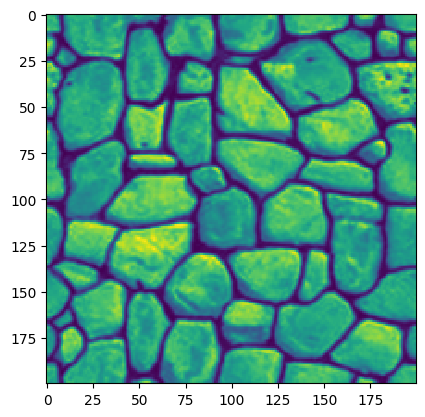

In [11]:
plt.imshow(a[0], interpolation='nearest')

## folder setup

In [12]:
# change yaml location here
with open(r"/home/mwegmann/g2s/notebooks/folder_gap_filling.yaml", "r") as f:
    directories = yaml.load(f, Loader=yaml.FullLoader)

In [13]:
#for d in directories.values():
#    if not os.path.exists(d):
#        os.makedirs(d)

In [14]:
# defining folders
input_folder=directories["g2s_input_folder"]

output_folder=directories["g2s_output_folder"]

scripts_folder=directories["scripts_folder"]

## Direct Sampling Coefficients

In [15]:
amount_member=50
test_runs=5

## read in data

In [16]:
meteo_orig=xr.open_dataset(input_folder+"meteo_1hr_g2s.nc")

In [17]:
meteo_orig

<xarray.Dataset>
Dimensions:   (time: 26280)
Coordinates:
  * time      (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    AirTC     (time) float64 ...
    RH        (time) float64 ...
    Slrw      (time) float64 ...
    WS        (time) float64 ...
    WindDir   (time) float64 ...
    Rain      (time) float64 ...
    BP        (time) float64 ...
    WindGust  (time) float64 ...

In [18]:
era5=xr.open_dataset(input_folder+"era5_lexplore_g2s.nc")

In [19]:
era5

<xarray.Dataset>
Dimensions:    (time: 26280)
Coordinates:
    longitude  float32 ...
    latitude   float32 ...
  * time       (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    u10        (time) float32 ...
    v10        (time) float32 ...
    t2m        (time) float32 ...
    sp         (time) float32 ...
    ssrd       (time) float32 ...
    tp         (time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-05 18:55:56 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [20]:
era5_land=xr.open_dataset(input_folder+"era5_land_lexplore_g2s.nc")

In [21]:
era5_land

<xarray.Dataset>
Dimensions:    (time: 26280)
Coordinates:
    longitude  float32 ...
    latitude   float32 ...
  * time       (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    sp         (time) float32 ...
    ssrd       (time) float32 ...
    t2m        (time) float32 ...
    tp         (time) float32 ...
    u10        (time) float32 ...
    v10        (time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-13 10:24:45 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Fill Air Temperature Data

### understand the average gap size in data

In [22]:
meteo_orig_airtc = meteo_orig.AirTC


In [23]:
compute_gap_sizes(meteo_orig_airtc)

array([ 48,  24,  72,  24, 156,  48,  96,  24,  24,  72, 168,   1,  96,
        16,   4,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1])

meteo_orig_airtc has 931 nans in 26280 data points
meteo_orig_airtc has 3.5426179604261794% missing values
meteo_orig_airtc has 73 gaps with 1.0 median gap size
meteo_orig_airtc has 73 gaps with 12.753424657534246 mean gap size


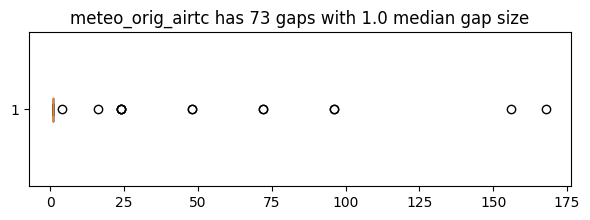

In [24]:
gap_info(meteo_orig_airtc, "meteo_orig_airtc")

In [25]:
np.isnan(meteo_orig_airtc.values).sum()

931

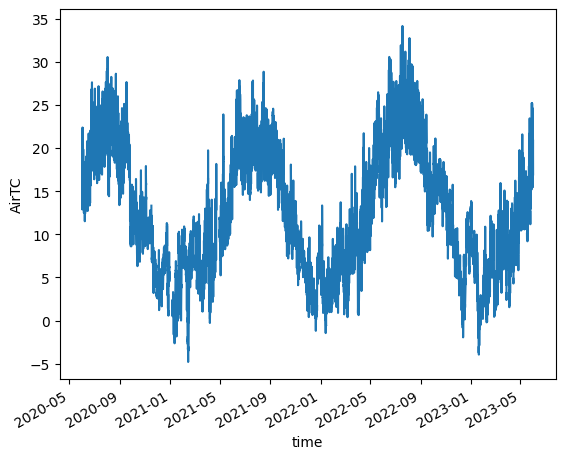

In [26]:
meteo_orig_airtc.plot()

### create replicable gaps

The idea is to create gaps that are always at the same position, but different in size.

It is tricky to think about a "perfect gap size" that we should try out. I would suggest that we try out gap sizes from 1 day (24 missing values in the case of the meteo station) towards 4 days (96 missing values in case of the meteo station).

The other question is how many (in %) new missing values do we introduce to evaluate our routine. The meteo station has 3% missing data as it is. Is 10% a good metric to evaluate? 20%?

In [27]:
def create_gaps_v2(var, gap_amount=10,max_gap_size = 24):
    """Creates new gaps in var with the by resampling from existing gap sizes 
    Returns var with gaps and a list with all indices of the gap locations"""
    new_var = var.copy()
    #gap_sizes = compute_gap_sizes(new_var) #number and size of gaps
    #gap_sizes[gap_sizes>max_gap_size] = max_gap_size
    #gap_distribution = DiscreteAliasUrn(gap_sizes) #distribution derived from gap_sizes, this didn't always work
    #new_gaps = gap_distribution.rvs(gap_number) #new realizations of this distribution
    gap_number=int(np.round(gap_amount/100*var.data.size))
    new_gaps = random.choices(sorted(list(gap_sizes)),k=gap_number)
    gap_indices = []
    for gap in new_gaps: #Try to find space for each new gap in the original data
        filled = False
        loop = 0
        while filled==False:
            if loop == 10000:
                print(f"Gap with size {gap} is too large")
                break
            rnd_idx = np.random.randint(0,len(new_var.data))
            if rnd_idx + gap >= len(new_var.data): # Out of bounds
                continue
            if np.count_nonzero(np.isnan(new_var.data[rnd_idx:rnd_idx+gap]))!=0: #Data already has gaps here
                continue
            timerange = slice(new_var.time[rnd_idx],new_var.time[rnd_idx+gap-1])
            new_var.loc[dict(time = timerange)] = np.nan
            for j in range(0,gap): 
                gap_indices.append(rnd_idx+j)
            filled = True
    return new_var, gap_indices

In [28]:
gap_sizes = compute_gap_sizes(meteo_orig_airtc) #number and size of gaps
gap_sizes

array([ 48,  24,  72,  24, 156,  48,  96,  24,  24,  72, 168,   1,  96,
        16,   4,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1])

In [29]:
gap_sizes[gap_sizes>24] = 24
gap_sizes

array([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,  1, 24, 16,  4,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1])

In [30]:
new_var=meteo_orig_airtc.copy()

In [31]:
len_new_var=new_var.data.size
gap_amount_per=10
gap_len=24
gap_amount_num=int(np.round(gap_amount_per/100*len_new_var))
gap_number=int(np.round(gap_amount_num/gap_len))

gap_location=[]
for i in range(gap_number):
    gap_location.append(randrange(len_new_var))

In [32]:
gap_locations=create_gap_index(da=meteo_orig_airtc,gap_percent=11,gap_length=24)

In [33]:
meteo_gapped_airtc_24_10=create_gapped_ts(da=meteo_orig_airtc,gap_locations=gap_locations,gap_length=24,selector=1)

Amount NAs in orig :931
Amount NAs in new :3646
10.331050228310502


In [34]:
create_gapped_ts(da=meteo_orig_airtc,gap_locations=gap_locations,gap_length=48,selector=2)

Amount NAs in orig :931
Amount NAs in new :3586
10.102739726027398


<xarray.DataArray 'AirTC' (time: 26280)>
array([15.576667, 14.49    , 13.751667, ..., 18.471667, 17.726667, 16.955   ])
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00

In [35]:
create_gapped_ts(da=meteo_orig_airtc,gap_locations=gap_locations,gap_length=72,selector=3)

Amount NAs in orig :931
Amount NAs in new :3625
10.251141552511415


<xarray.DataArray 'AirTC' (time: 26280)>
array([15.576667, 14.49    , 13.751667, ..., 18.471667, 17.726667, 16.955   ])
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00

In [36]:
create_gapped_ts(da=meteo_orig_airtc,gap_locations=gap_locations,gap_length=96,selector=4)

Amount NAs in orig :931
Amount NAs in new :3394
9.372146118721462


<xarray.DataArray 'AirTC' (time: 26280)>
array([15.576667, 14.49    , 13.751667, ..., 18.471667, 17.726667, 16.955   ])
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00

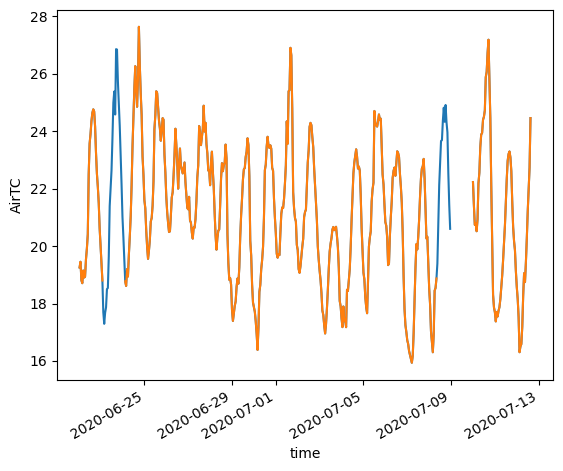

In [37]:

meteo_orig_airtc[505:1000].plot()
meteo_gapped_airtc_24_10[505:1000].plot()


## Run gapfilling

In [38]:

gap_amount_list=[24,48,72,96]
selector_list=[1,2,3,4]
#gap_amount_list=[150]
N = amount_member
runs=test_runs


In [45]:
gapped_data=meteo_gapped_airtc_24_10
original = meteo_orig_airtc

In [40]:
L = gapped_data.data.size
sin_calendar = sin_costfunction(L,daily_timesteps = 24)
cos_calendar = cos_costfunction(L,daily_timesteps = 24)
timeofday = meteo_orig_airtc.time.dt.hour.values #Ca

In [41]:
#Univariate gap-filling
ti = gapped_data.data
di = gapped_data.data
dt = [0]

UV_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
UV_simulations = xr.DataArray(data =UV_stacked,coords = {'realizations':np.arange(1,UV_stacked.shape[0]+1),'time':gapped_data.time})

job Id is: 4164387417
progress 100.000%       
        job Id is: 2466003347
progress 100.000%       
        job Id is: 767735807
progress 100.000%       
        job Id is: 3370774666
progress 100.000%       
        job Id is: 1674638427
progress 100.000%       
        job Id is: 4290398275
progress 100.000%       
        job Id is: 2592033316
progress 100.000%       
        job Id is: 895294659
progress 100.000%       
        job Id is: 3483342979
progress 100.000%       
        job Id is: 2408253861
progress 100.000%       
        job Id is: 1939467371
progress 100.000%       
        job Id is: 863573492
progress 100.000%       
        job Id is: 4072609501
progress 100.000%       
        job Id is: 2989106972
progress 100.000%       
        job Id is: 1904108856
progress 100.000%       
        job Id is: 818459373
progress 100.000%       
        job Id is: 4028217698
progress 100.000%       
        job Id is: 2953153334
progress 100.000%       
        job Id is: 187

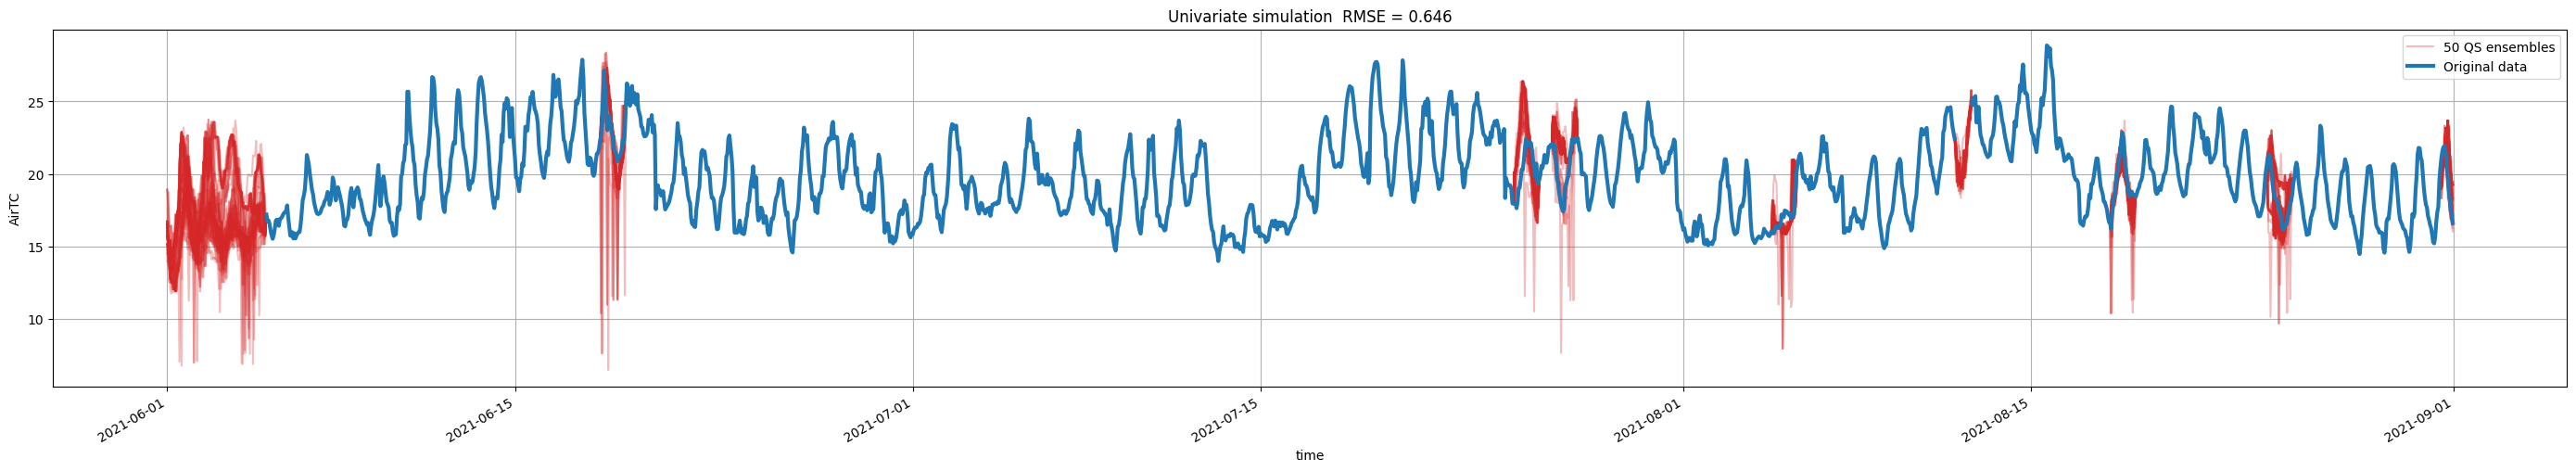

In [46]:
year = 2021
start_month =6
end_month = 8

plot_MPS_ensembles(original = original,
                   simulation = UV_simulations, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,
                  alpha = 0.3,
                  title = 'Univariate simulation ')

In [57]:
corr=np.round(xr.corr(original, UV_simulations, dim="time").mean(dim="realizations").values,4)
error = np.round(np.sqrt(np.nanmean((UV_simulations.data-original.data)**2)),4)
std_ratio=(original/UV_simulations).mean(dim="realizations").mean(dim="time").values

In [48]:
corr

0.9958

In [49]:
error

0.6461

In [58]:
std_ratio

array(1.00422293)

In [ ]:
# still looking for a good wavelet analysis
# something easy like https://github.com/jkrasting/xwavelet/blob/main/example_usage.ipynb
# but I couldnt make that work

In [ ]:
end

In [ ]:
for N in N_list:
  for gap_amount in gap_amount_list:


    for i in range(runs):

      gapped_data, gap_indices = create_gaps(original,gap_number = gap_amount)
      L = gapped_data.data.size
      sin_calendar = sin_costfunction(L,daily_timesteps = 24)
      cos_calendar = cos_costfunction(L,daily_timesteps = 24)
      timeofday = original.time.dt.hour.values #Categorical variable, the category "12pm" is as distant to the category "12am" as "6am"


      print("This is run "+str(i)+" with N="+str(N)+" and GN="+str(gap_amount))


      #Univariate gap-filling
      ti = gapped_data.data
      di = gapped_data.data
      dt = [0]

      UV_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)
      UV_simulations = xr.DataArray(data =UV_stacked,coords = {'realizations':np.arange(1,UV_stacked.shape[0]+1),'time':gapped_data.time})


      #Meteo AirTC with calendar day
      ti = np.stack([gapped_data.data,sin_calendar,cos_calendar],axis = 1)
      di = np.stack([gapped_data, sin_calendar,cos_calendar],axis = 1)
      dt = [0,0,0] #3 continuous variables

      MV1_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)
      MV1_simulations = xr.DataArray(data =MV1_stacked[:,:,0], 
                                    coords = {'realizations':np.arange(1,MV1_stacked.shape[0]+1),'time':gapped_data.time})

      #gap-filling with calendar day and time of day 
      ti = np.stack([gapped_data.data,
                    sin_calendar,
                    cos_calendar,
                    timeofday],axis = 1)
      di = np.stack([ gapped_data.data,
                    sin_calendar,
                    cos_calendar,
                    timeofday],axis = 1)
      #ki = np.ones([L,4])
      #ki[:,:3] = 0.5 #Assign half weight to categorical variable 
      dt = [0,0,0,1]  #time of day is a categorical variable

      MV2_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)

      MV2_simulations = xr.DataArray(data =MV2_stacked[:,:,0],
                                    coords = {'realizations':np.arange(1,MV2_stacked.shape[0]+1),'time':gapped_data.time})          


In [ ]:
year = 2020
start_month =6
end_month = 8

plot_MPS_ensembles(original = meteo.AirTC,
                   simulation = UV_simulations, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,
                  alpha = 0.3,
                  title = 'Univariate simulation ')

plot_MPS_ensembles(original = meteo.AirTC,
                   simulation = MV1_simulations, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,
                  alpha = 0.3,
                  title = 'Simulation with seasonality covariable ')

plot_MPS_ensembles(original = meteo.AirTC,
                   simulation = MV2_simulations, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,
                  alpha = 0.3,
                  title = 'Simulation with seasonality and time of day covariables ')

In [ ]:
#Prepare data
original = meteo.AirTC




corr_score=[]
rmse_score=[]

for N in N_list:
  for gap_amount in gap_amount_list:


    for i in range(executions):

      gapped_data, gap_indices = create_gaps(original,gap_number = gap_amount)
      L = gapped_data.data.size
      sin_calendar = sin_costfunction(L)
      cos_calendar = cos_costfunction(L)
      timeofday = np.array([0,1,2,3]*np.ceil(L/4).astype(int))[:L] #Categorical variable, the category "12pm" is as distant to the category "12am" as "6am"


      print("This is run "+str(i)+" with N="+str(N)+" and GN="+str(gap_amount))


      #Univariate gap-filling
      ti = gapped_data.data
      di = gapped_data.data
      dt = [0]

      UV_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)
      UV_simulations = xr.DataArray(data =UV_stacked,coords = {'realizations':np.arange(1,UV_stacked.shape[0]+1),'time':gapped_data.time})


      #Meteo AirTC with calendar day
      ti = np.stack([gapped_data.data,sin_calendar,cos_calendar],axis = 1)
      di = np.stack([gapped_data, sin_calendar,cos_calendar],axis = 1)
      dt = [0,0,0] #3 continuous variables

      MV1_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)
      MV1_simulations = xr.DataArray(data =MV1_stacked[:,:,0], 
                                    coords = {'realizations':np.arange(1,MV1_stacked.shape[0]+1),'time':gapped_data.time})

      #gap-filling with calendar day and time of day 
      ti = np.stack([gapped_data.data,
                    sin_calendar,
                    cos_calendar,
                    timeofday],axis = 1)
      di = np.stack([ gapped_data.data,
                    sin_calendar,
                    cos_calendar,
                    timeofday],axis = 1)
      #ki = np.ones([L,4])
      #ki[:,:3] = 0.5 #Assign half weight to categorical variable 
      dt = [0,0,0,1]  #time of day is a categorical variable

      MV2_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)

      MV2_simulations = xr.DataArray(data =MV2_stacked[:,:,0],
                                    coords = {'realizations':np.arange(1,MV2_stacked.shape[0]+1),'time':gapped_data.time})          

      
      #gap-filling with calendar day and Pressure and Windspeed

      #Create gaps at the same locations as AirTC
      covar1 = meteo.BP.copy()
      covar1.loc[dict(time = covar1.time[gap_indices])] = np.nan
      covar2 = meteo.Slrw.copy()
      covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan

      ti = np.stack([gapped_data.data,
                    sin_calendar,
                    cos_calendar,
                    covar1,
                    covar2],axis = 1)
      di = np.stack([gapped_data.data,
                    sin_calendar,
                    cos_calendar,
                    covar1,
                    covar2],axis = 1)
      dt = [0,0,0,0,0] 
      #ki = np.ones([L,5])
      #ki[:,:4] = 0.3 #Assign half weight to categorical variable 


      MV3_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)
      MV3_simulations = xr.DataArray(data =MV3_stacked[:,:,0],
                                    coords = {'realizations':np.arange(1,MV3_stacked.shape[0]+1),'time':gapped_data.time})                      

      #gap-filling with shortwave

      #Create gaps at the same locations as AirTC

      covar2 = meteo.Slrw.copy()
      covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan

      ti = np.stack([gapped_data.data,
                    covar2],axis = 1)
      di = np.stack([gapped_data.data,
                    covar2],axis = 1)
      dt = [0,0,] 
      #ki = np.ones([L,5])
      #ki[:,:4] = 0.3 #Assign half weight to categorical variable 


      MV4_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)
      MV4_simulations = xr.DataArray(data =MV4_stacked[:,:,0],
                                    coords = {'realizations':np.arange(1,MV4_stacked.shape[0]+1),'time':gapped_data.time})
      
      #gap-filling with era t2m

      #Create gaps at the same locations as AirTC

      covar2 = era5_land.t2m.copy()
      covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan

      ti = np.stack([gapped_data.data,
                    covar2],axis = 1)
      di = np.stack([gapped_data.data,
                    covar2],axis = 1)
      dt = [0,0,] 
      #ki = np.ones([L,5])
      #ki[:,:4] = 0.3 #Assign half weight to categorical variable 


      MV5_stacked = ensemble_QS(N = N,
                              ti=ti, 
                              di=di,
                              dt=dt, #Zero for continuous variables
                              k=1.2,
                              n=50,
                              j=0.5,
                              ki=None)
      MV5_simulations = xr.DataArray(data =MV5_stacked[:,:,0],
                                    coords = {'realizations':np.arange(1,MV5_stacked.shape[0]+1),'time':gapped_data.time})
      
      # Compute correlation between simulation and observation in the artificial gaps

      UV_corr=np.round(xr.corr(original, UV_simulations, dim="time").mean(dim="realizations").values,4)
      MV1_corr=np.round(xr.corr(original, MV1_simulations, dim="time").mean(dim="realizations").values,4)
      MV2_corr=np.round(xr.corr(original, MV2_simulations, dim="time").mean(dim="realizations").values,4)
      MV3_corr=np.round(xr.corr(original, MV3_simulations, dim="time").mean(dim="realizations").values,4)
      MV4_corr=np.round(xr.corr(original, MV4_simulations, dim="time").mean(dim="realizations").values,4)
      MV5_corr=np.round(xr.corr(original, MV5_simulations, dim="time").mean(dim="realizations").values,4)
      corr_vector=[UV_corr, MV1_corr,MV2_corr,MV3_corr,MV4_corr,MV5_corr]
      print("Correlation Skill")
      print(UV_corr, MV1_corr,MV2_corr,MV3_corr,MV4_corr,MV5_corr)

      # Compute RMSE between simulation and observation in the artificial gaps
      UV_error = np.round(np.sqrt(np.nanmean((UV_simulations.data-original.data)**2)),4)
      MV1_error = np.round(np.sqrt(np.nanmean((MV1_simulations.data-original.data)**2)),4)
      MV2_error = np.round(np.sqrt(np.nanmean((MV2_simulations.data-original.data)**2)),4)
      MV3_error = np.round(np.sqrt(np.nanmean((MV3_simulations.data-original.data)**2)),4)
      MV4_error = np.round(np.sqrt(np.nanmean((MV4_simulations.data-original.data)**2)),4)
      MV5_error = np.round(np.sqrt(np.nanmean((MV5_simulations.data-original.data)**2)),4)
      error_vector=[UV_error, MV1_error,MV2_error,MV3_error,MV4_error,MV5_error]
      print("RMSE Skill")
      print(UV_error, MV1_error,MV2_error,MV3_error,MV4_error,MV5_error)

      corr_score.append(corr_vector)
      rmse_score.append(error_vector)

print(np.asarray(corr_score).mean(axis=0))
print(np.asarray(rmse_score).mean(axis=0))